## 4. CRISP-DM: Data Preparation

In [1711]:

# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import display
import re
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from IPython.display import display, Markdown
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler


from imblearn.over_sampling import SMOTE 
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, confusion_matrix, recall_score, precision_score, roc_curve, f1_score

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # Render high resolution images

# Load datasets
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
weather = pd.read_csv('../data/weather.csv')
spray = pd.read_csv('../data/spray.csv')


In [1712]:
# Method for displaying datra
def display_all():
  display(weather.head())
  display(train.head())
  display(test.head())
  display(spray.head())


### 4.1 Data Selection

#### Feature Extraction

**Extracting Month and Year**

In [1713]:


def preprocess_date(df):
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    # exracted year and month because ... TODO
    df['Year Month'] =  df['Date'].dt.strftime('%Y %m')
    return df
for df in [train, test, weather, spray]:
     df['Date'] = pd.to_datetime(df['Date'])
     # test and train do not need to be preprocessed as they will be merged dduring Data Integration     
for df in [weather, spray]:
    df = preprocess_date(df)



**Extracting Number of WNV Cases Per Location**

       WnvPresent
count       138.0
mean          4.0
std           7.0
min           0.0
25%           0.0
50%           2.0
75%           6.0
max          66.0


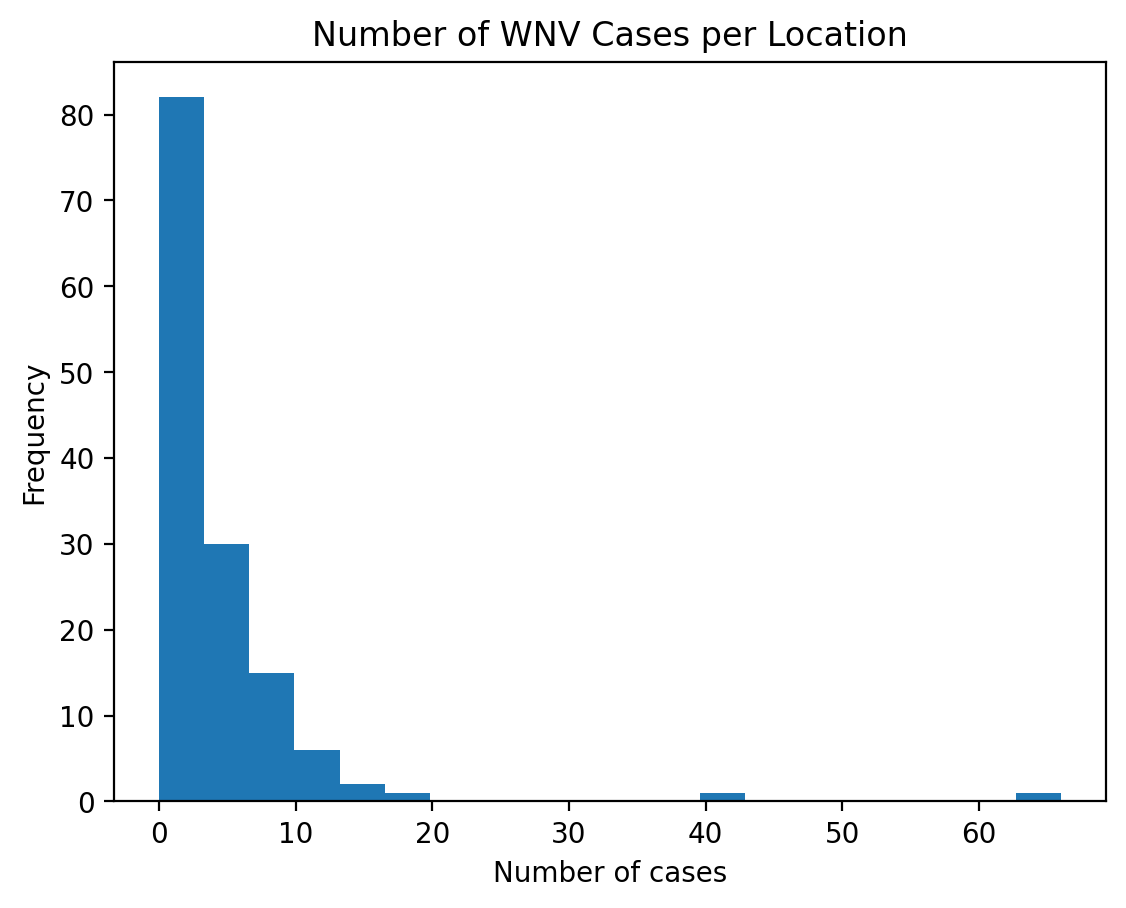

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,WnvRisk_very low,WnvRisk_low,WnvRisk_medium,WnvRisk_high
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,False,False,False,True
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,False,False,False,True
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,True,False,False,False
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,False,True,False,False
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,False,True,False,False


In [1714]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'train' is your DataFrame containing the data
# Create a pivot table to sum the number of WNV cases detected at each location
wnv_risk = train.groupby('Address').agg({'WnvPresent': 'sum'}).reset_index()

# Display statistics of WNV cases detected
print(wnv_risk.describe().round()) 

# Plot histogram to show the spread in the number of WNV cases detected
plt.title("Number of WNV Cases per Location")
plt.ylabel("Frequency")
plt.xlabel("Number of cases")
plt.hist(wnv_risk['WnvPresent'], bins=20)
plt.show()

# Define bins and labels - Risk Assesment 0 cases, very low, 2 - low, 6 - medium, 10 - high
bins = [0, 2, 6, 10, float('inf')]
labels = ['very low', 'low', 'medium', 'high']

# Create the WNV_risk feature
wnv_risk['WNV_risk'] = pd.cut(wnv_risk['WnvPresent'], bins=bins, right=False, labels=labels, ordered=True)


# Merge risk data with train data, dummify the categorical variable, and drop original
train = train.merge(wnv_risk[['Address', 'WNV_risk']], how='left', on='Address')
train = pd.get_dummies(train, columns=['WNV_risk'], prefix='WnvRisk')

display(train.head())


Extracting Feature Relative Humidity

In [1715]:
# The weather conditions are encoded in the CodeSum column. We weill use Rainy, Snowy, Windy, Hazy as Umbrella Terms for various Conditions
weather["CodeSum"].unique()

# List of valid weather codes
codes = ['+FC','FC', 'TS', 'GR', 'RA', 'DZ', 'SN', 'SG', 'GS', 'PL',
         'IC', 'FG+', 'FG', 'BR', 'UP', 'HZ', 'FU', 'VA', 'DU', 'DS',
         'PO', 'SA', 'SS', 'PY', 'SQ', 'DR', 'SH', 'FZ', 'MI', 'PR',
         'BC', 'BL', 'VC']

# Function to clean and filter codes in CodeSum
def clean_codes(code_string):
    filtered_codes = [code for code in code_string.split() if code in codes]
    return ' '.join(filtered_codes)

# Apply the function to the CodeSum column
weather['CodeSum'] = weather['CodeSum'].apply(clean_codes)

# Define a dictionary for conditions and their corresponding weather codes
conditions = {
    "Rainy": ['TS', 'RA', 'DZ', 'SH'],
    "Snowy": ['SN', 'SG', 'GS', 'PL', 'IC', 'DR', 'BC', 'GR'],
    "Windy": ['SQ', 'DS', 'SS', 'PO', 'BL'],
    "Hazy": ['BR', 'HZ', 'FG', 'FU']
}

# Function to create dummy variables based on conditions
def mark_conditions(row, condition_codes):
    return any(code in row['CodeSum'].split() for code in condition_codes)

# Apply the function to create dummy columns for each condition
for condition, codes in conditions.items():
    weather[condition] = weather.apply(mark_conditions, condition_codes=codes, axis=1).astype(int)





In [1716]:
display(train.head())

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,WnvRisk_very low,WnvRisk_low,WnvRisk_medium,WnvRisk_high
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,False,False,False,True
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,False,False,False,True
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,True,False,False,False
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,False,True,False,False
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,False,True,False,False


**Assigning a station based on longitude and latitude**: This feature Is necessary for Data Integration (merging the 2 Dataframes)

In [1717]:
from geopy.distance import geodesic

def assign_station_v2(lat, lng):
    station1_coordinates  = (41.995, -87.933)
    station2_coordinates  = (41.786, -87.752)
    coord_curr = (lat, lng)
    distance_to_stn1 = geodesic(coord_curr, station1_coordinates ).miles
    distance_to_stn2 = geodesic(coord_curr, station2_coordinates ).miles
    return 1 if distance_to_stn1 < distance_to_stn2 else 2

train['Station'] = train.apply(lambda row: assign_station_v2(row['Latitude'], row['Longitude']), axis=1)


<div style="color:red;">???? ⬇️<div> - Is It necessary to use more advanced feature selection Techniques such as $X^2$ or does domain knowledge suffice?




In order to reduce the complexity and choose the most important features, we used general knowledge and domain knowledge.

#### Train and Test Data

**Features to Keep:**
- **`Date`**: Temporal patterns can influence mosquito activity and WNV presence. [2]
- **`Species`**: Different mosquito species have varying propensities to carry WNV. [3]
- **`Address`**: Geographic location is critical for spatial analysis of virus presence. Using address instead of coordinates allows us to categorize coordinates and assign them with a risk level (see code above).
- **`Trap`**: Specific traps might have consistent results based on their locations.
- **`NumMosquitos`**: Higher mosquito counts might correlate with a higher likelihood of virus presence.

**Features to Drop:**
- ~~**`Block`**~~: Redundant when using Latitude and Longitude.
- ~~**`Street`**~~: Not useful for modeling; geographical coordinates are more precise.
- ~~**`AddressNumberAndStreet`**~~: Redundant when using Address.
- ~~**`AddressAccuracy`**~~: Provided geocoded data already has adequate accuracy.
- ~~**`Latitude`**, **`Longitude`**~~: Already using Address.

#### Weather Data

"Mosquito seasonal activity is largely driven by weather conditions, most notably temperature, precipitation, and relative humidity." [5]

**Features to Keep:**
- **`Station`**: Different weather stations can provide location-specific weather data.
- **`Date`**: Temporal patterns can influence mosquito activity and WNV presence. [2]
- **`Tmax`**, **`Tmin`**, **`Tavg`**: Temperature extremes and averages can influence mosquito behavior. [2]
- **`DewPoint`**: Indicator of moisture in the air, which can affect mosquito breeding.
- **`PrecipTotal`**: Total precipitation; standing water is critical for mosquito breeding.
- **`StnPressure`**: Has an impact on population [7]
- **`ResultSpeed`**, **`ResultDir`**, **`AvgSpeed`**: Wind speed and direction are not nearly as relevant as temperature, precipitation, and relative humidity, but should still be icnluded, as it can affect flight activity [8].

**Features to Drop:**
- ~~**`Depth`**~~: Unnecessary, since we already have precipitation
- ~~**`SeaLevel`**~~: Likely has very little impact especially, since chicago isn't a coastal city
- ~~**`Depart`**~~: Departure from average might not be as useful as absolute values.
- ~~**`WetBulb`**~~: Similar information provided by DewPoint.
- ~~**`Heat`**, **`Cool`**~~: Redundant when using temperature data.
- ~~**`Sunrise`**, **`Sunset`**~~: Not as relevant as the other weather conditions [5]
- ~~**`CodeSum`**~~: We've already extracted a feature which aggregates these
- ~~**`SnowFall`**~~: Mosquitoes only exist in dormancy during winter (or when it snows) and do not breed or thrive in any capacity. [6]
- ~~**`Water1`**~~: Only has missing values.


#### Spray Data

**Features to Keep:**
- **`Date`**: Temporal alignment with mosquito data.
- **`Time`**: Time of day might influence effectiveness.
- **`Latitude`**, **`Longitude`**: Location of spraying is crucial for understanding its impact.

## References

[1] https://www.mdpi.com/2225-1154/7/9/101#:~:text=In%20climate%20science%2C%20climate%20departure,27%2C28%2C29%5D.

[2] https://eu.usatoday.com/story/news/2023/05/29/how-long-do-mosquitoes-live/70228628007/

[3] https://www.epa.gov/sites/default/files/2021-01/documents/wetlands_west_nile_virus.pdf

[4] https://www.wearegreenbay.com/weather/beyondtheforecast/what-weather-conditions-lead-to-mosquitos-being-more-active/#:~:text=Temperatures%20can%20get%20too%20hot,the%20cooler%20temperatures%20of%20winter.

[5] https://parasitesandvectors.biomedcentral.com/articles/10.1186/s13071-023-05760-x

[6] https://www.vdci.net/blog/where-do-mosquitoes-go-in-the-winter/#:~:text=By%20entering%20a%20state%20of,areas%20with%20significant%20seasonal%20variation.

[7] https://www.redalyc.org/journal/5763/576366658009/html/

[8]

In [1718]:

weather.drop(["SeaLevel", "Depart", "WetBulb", "Heat", "Cool", "Sunrise", "Sunset", "CodeSum", "SnowFall", "Water1", "Depth"], axis=1, inplace=True)
for df in [train, test]:
  df.drop(["Block", "Street", "AddressNumberAndStreet", "AddressAccuracy", "Latitude", "Longitude"], axis=1, inplace=True)





### 4.2 Data Cleaning Based on Steps Outlined in [Slides for Data Preparation](/Vorlesungen/2024_08_Data%20Preparation.pdf) 

### Before

#### Data Cleansing

In [1719]:
text_columns = ['Address', 'Species']


##### Turn all characters into capital letters to level case sensitivity

In [1720]:


def level_case_sensitivity(df, columns):
    for column in columns:
        df[column] = df[column].str.upper()
        df[column] = df[column].str.strip()
    return df

train = level_case_sensitivity(train, text_columns)
test = level_case_sensitivity(test, text_columns)




##### Remove spaces and non-printing characters (\n, \t etc.)

In [1721]:

def rm_spaces_nonprinting_chars(df, columns):
    for column in columns:
        df[column] = df[column].apply(lambda x: re.sub(r'[\n\t]', '', x) if isinstance(x, str) else x)
        # df[column] = df[column].apply(lambda x: replace_abbreviations(x, abbreviations) if isinstance(x, str) else x)
    return df
train = rm_spaces_nonprinting_chars(train, text_columns)
test = rm_spaces_nonprinting_chars(test, text_columns)



##### Fix the format of numbers, data, and time (decimal point! Datetime objects or standard date format, i.e. YYYY-MM-DD)

In [1722]:
# This has already been done

##### Use spell-checker or stemming to normalize spelling

In [1723]:
# In our case this is not necessary, since he text fields are already cleaned (Address/ Species, etc.)


##### Normalize the writing of addresses and names, possibly ignoring the order of title, surname, forename, etc. to ease their re-identification

##### Convert numerical values into standard units, especially if data from different sources and different countries are used

In [1724]:
import pandas as pd

# Define conversion functions
def fahrenheit_to_celsius(f):
    return round((f - 32) * 5.0 / 9.0, 2)

def inhg_to_mbar(inhg):
    return round(inhg * 33.8639, 2)

def mph_to_kmph(mph):
    return round(mph * 1.60934, 2)

# Convert relevant columns to numeric type if they are not already
numeric_columns = ['Tmax', 'Tmin', 'Tavg', 'StnPressure', 'AvgSpeed', 'ResultSpeed']
weather[numeric_columns] = weather[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Applying conversions to the DataFrame
weather['Tmax'] = weather['Tmax'].apply(fahrenheit_to_celsius)
weather['Tmin'] = weather['Tmin'].apply(fahrenheit_to_celsius)
weather['Tavg'] = weather['Tavg'].apply(fahrenheit_to_celsius)
weather['StnPressure'] = weather['StnPressure'].apply(inhg_to_mbar)
weather['AvgSpeed'] = weather['AvgSpeed'].apply(mph_to_kmph)
weather['ResultSpeed'] = weather['ResultSpeed'].apply(mph_to_kmph)


# Print updated dataframe to check changes
display(weather.head())


,Station,Date,Tmax,Tmin,Tavg,DewPoint,PrecipTotal,StnPressure,ResultSpeed,ResultDir,AvgSpeed,Year,Month,Day,Year Month,Rainy,Snowy,Windy,Hazy
0,1,2007-05-01,28.33,10.00,19.44,51,0.00,985.44,2.74,27,14.81,2007,5,1,2007 05,0,0,0,0
1,2,2007-05-01,28.89,11.11,20.00,51,0.00,988.15,4.35,25,15.45,2007,5,1,2007 05,0,0,0,0
2,1,2007-05-02,15.00,5.56,10.56,42,0.00,994.92,20.92,4,21.57,2007,5,2,2007 05,0,0,0,1
3,2,2007-05-02,15.56,6.11,11.11,42,0.00,996.95,21.40,2,21.57,2007,5,2,2007 05,0,0,0,1
4,1,2007-05-03,18.89,7.78,13.33,40,0.00,995.26,18.83,7,19.15,2007,5,3,2007 05,0,0,0,0



##### Use dictionaries containing all possible values of an attribute to assure that all values comply with the domain knowledge

In [1725]:
import os
import json
import pandas as pd

def write_unique_values_to_json(dataframes, output_directory):
    # Ensure the output directory exists
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Function to handle non-serializable data types
    def default_converter(o):
        if isinstance(o, pd.Timestamp):
            return o.isoformat()
        raise TypeError(f"Object of type {o.__class__.__name__} is not JSON serializable")
    
    # Iterate over each dataframe
    for df in dataframes:
        # Ensure the dataframe has a name attribute
        if not hasattr(df, 'name'):
            raise AttributeError("DataFrame is missing a 'name' attribute")
        
        # Create a dictionary to store unique values for each column
        unique_values_dict = {}
        
        # Iterate over each column in the dataframe
        for column in df.columns:
            # Get unique values and convert them to a list
            unique_values = df[column].dropna().unique().tolist()
            # Convert any non-serializable items
            unique_values = [x if isinstance(x, (int, float, str)) else default_converter(x) for x in unique_values]
            # Store unique values in the dictionary
            unique_values_dict[column] = unique_values
        
        # Construct the output file path
        output_file = os.path.join(output_directory, f'{df.name}_unique_values.json')
        
        # Write the unique values dictionary to a JSON file
        with open(output_file, 'w') as f:
            json.dump(unique_values_dict, f, indent=4)
        
        print(f'Unique values for {df.name} written to {output_file}')

# Example usage
train.name = 'train'
test.name = 'test'
weather.name = 'weather'
spray.name = 'spray'

# Specify output directory
output_directory = '../data/unique_values_output'

# Call the function with the list of DataFrames
write_unique_values_to_json([train, test, weather, spray], output_directory)


Unique values for train written to ../data/unique_values_output\train_unique_values.json
Unique values for test written to ../data/unique_values_output\test_unique_values.json
Unique values for weather written to ../data/unique_values_output\weather_unique_values.json
Unique values for spray written to ../data/unique_values_output\spray_unique_values.json


#### Missing Values


In [1726]:
import pandas as pd
from IPython.display import display, Markdown

# Predefined list of missing value indicators
missing_values = ['', 'M', '-']
low_values=['T', ' T', '  T']
def analyze_dataframe(df, name):
    # Displaying the name of the DataFrame
    display(Markdown(f"### {name} DataFrame Analysis"))

    # Displaying the number of missing values calculated by isnull()
    null_values = df.isnull().sum()
    if null_values.any():
        display(null_values[null_values > 0])
        display(Markdown("\n**Missing Values in Each Column (Detected by `isnull()`):**"))
    else:
        display(Markdown("\n**No Missing Values Detected by `isnull()`**"))

    # Displaying the number of duplicate rows in the DataFrame
    duplicate_count = df.duplicated().sum()
    if duplicate_count > 0:
        display(Markdown("\n**Number of Duplicate Rows:**"))
        display(duplicate_count)
    else:
        display("No duplicate rows found in the DataFrame.")
    # Looping through each custom missing value indicator to display counts
    for value in missing_values:
        specific_value_count = df.isin([value]).sum()
        if specific_value_count.any():
            display(Markdown(f"\n**Count of '{value}' Values in Each Column:**"))
            display(specific_value_count[specific_value_count > 0].sort_values(ascending=False))
    
    # Calculating total missing data including custom missing values without replacing DataFrame

    total_missing_per_column = df.isnull().sum()  # start with null values
    for value in missing_values:
        total_missing_per_column += df.isin([value]).sum()

    # Calculating the percentage of total missing data for each column
    total_entries = len(df)
    missing_percentage = (total_missing_per_column / total_entries * 100).round(2)
    
    # Displaying the percentage of missing data
    missing_info = missing_percentage[missing_percentage > 0].astype(str) + '% (' + total_missing_per_column[total_missing_per_column > 0].astype(str) + '/' + str(total_entries) + ')'
    if(missing_info.any()):
        display(Markdown("\n**Detailed Missing Values Analysis**"))
        display(Markdown("\n**Percentage of Total Missing Data in Each Column:**"))
        display(missing_info)
    else:
        display(Markdown("\n**No Missing Values Detected**"))


analyze_dataframe(weather, "WEATHER")
analyze_dataframe(train, "TRAIN")
analyze_dataframe(test, "TEST")
analyze_dataframe(spray, "SPRAY")

### WEATHER DataFrame Analysis

Tavg           11
StnPressure     4
AvgSpeed        3
dtype: int64


**Missing Values in Each Column (Detected by `isnull()`):**

'No duplicate rows found in the DataFrame.'


**Count of 'M' Values in Each Column:**

PrecipTotal    2
dtype: int64


**Detailed Missing Values Analysis**


**Percentage of Total Missing Data in Each Column:**

Tavg           0.37% (11/2944)
PrecipTotal     0.07% (2/2944)
StnPressure     0.14% (4/2944)
AvgSpeed         0.1% (3/2944)
dtype: object

### TRAIN DataFrame Analysis


**No Missing Values Detected by `isnull()`**


**Number of Duplicate Rows:**

813


**No Missing Values Detected**

### TEST DataFrame Analysis


**No Missing Values Detected by `isnull()`**

'No duplicate rows found in the DataFrame.'


**No Missing Values Detected**

### SPRAY DataFrame Analysis

Time    584
dtype: int64


**Missing Values in Each Column (Detected by `isnull()`):**


**Number of Duplicate Rows:**

541


**Detailed Missing Values Analysis**


**Percentage of Total Missing Data in Each Column:**

Time    3.94% (584/14835)
dtype: object

In [1727]:

# Function to replace custom missing values with None
def standardize_missing_values(df, missing_values):
    return df.replace(missing_values, np.nan, inplace=True)



for df in [train, test, weather, spray]:
    df = standardize_missing_values(df, missing_values)





##### Spray

In [1728]:
# Spray has duplicate Rows, which we will remove
spray.drop_duplicates(keep="first", inplace=True, ignore_index=True)

# Spray also has missing entries for Time, which simply can't be imputed, so we will drop these rows
spray.drop(["Time"], axis=1, inplace=True)

analyze_dataframe(spray, "SPRAY")




### SPRAY DataFrame Analysis


**No Missing Values Detected by `isnull()`**

'No duplicate rows found in the DataFrame.'


**No Missing Values Detected**



##### Weather



<div style="color:red;">???? ⬇️<div> - Since we have so few missing values, we used the median - is this alright or do we need to do extensive analysis to determine if values are MCAR, MAR, etc.

In [1729]:

# Tavg can easily be imputed by averaging Tmax and Tmin


weather['Tavg'] = (weather['Tmax'] + weather['Tmin']) / 2

# Insignificant Precipitation is marked as 'T'. We will replace it with 0
weather['PrecipTotal'].replace(low_values, 0, inplace=True)

# PrecipTotal only has 2 missing values, so we can fill them in

weather['PrecipTotal'] = weather['PrecipTotal'].fillna(method='ffill')

# The other missing features are StnPressure, AvgSpeed and SeaLevel. We will fill them with the median value
weather["StnPressure"].fillna(weather["StnPressure"].median(), inplace=True)
weather["AvgSpeed"].fillna(weather["AvgSpeed"].median(), inplace=True)
# Furthermore, we want to convert numerical features to a niumvber

weather["StnPressure"] = weather["StnPressure"].astype(float)
weather["PrecipTotal"] = weather["PrecipTotal"].astype(float)






C:\Users\nilst\AppData\Local\Temp\ipykernel_12268\4028783608.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather['PrecipTotal'] = weather['PrecipTotal'].fillna(method='ffill')



<div style="color:red;">???? ⬇️<div> - We extracted feature RelativeHumidity here, because prior to filling missing values, extracting this feature would have resulted in missing values

In [1730]:

weather['DewPoint'] = pd.to_numeric(weather['DewPoint'])
weather['Tavg'] = pd.to_numeric(weather['Tavg'])

# Now calculate Relative Humidity
weather['RelativeHumidity'] = 100 * (
    np.exp((17.67 * ((weather['DewPoint'] - 32) * (5 / 9))) / (243.5 + ((weather['DewPoint'] - 32) * (5 / 9)))) /
    np.exp((17.67 * ((weather['Tavg'] - 32) * (5 / 9))) / (243.5 + ((weather['Tavg'] - 32) * (5 / 9))))
)

# Round the Relative Humidity to 2 decimals
weather['RelativeHumidity'] = weather['RelativeHumidity'].round(2)





##### TRAIN

In [1731]:
# TRAIN has duplicate Rows, which we will remove
train.drop_duplicates(keep="first", inplace=True, ignore_index=True)

analyze_dataframe(train, "TRAIN")

### TRAIN DataFrame Analysis


**No Missing Values Detected by `isnull()`**

'No duplicate rows found in the DataFrame.'


**No Missing Values Detected**

- **Turn the considered attribute 𝑋 into a binary attribute, replacing all measured values by “yes” and all missing values by “no”**
- **Build a classifier with the now binary attribute 𝑋 as the target attribute, and use all other attributes for the prediction of the class values “yes” and “no”**
- **Determine the misclassification rate, which is the proportion of data objects that are not assigned to the correct class by the classifier.**

##### Outlier Detection


<div style="color:red;">???? ⬇️<div> 

- We used the five number summary and boxplots for numerical attributes? - We have a few outliers, but none of them are unrealistic values - do we need to do any additional analysis of these or may we proceed?

- We used frequency analysis for categorical attributes

In [1732]:
import pandas as pd

import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_category_frequencies_grid(df):
    # Filter out categorical columns
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object' or pd.api.types.is_categorical_dtype(df[col])]
    
    # Determine the layout of the grid based on the number of categorical columns
    n_cols = min(3, len(categorical_columns))  # Use up to 3 columns in the grid
    n_rows = (len(categorical_columns) + 2) // 3  # Calculate required rows, rounded up

    # Setup the figure and axes
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))  # Increased width for better label fitting
    fig.suptitle('Frequency of Categories in Each Column')

    # Loop over the grid and plot each variable
    for ax, column in zip(axes.flatten(), categorical_columns):
        # Get the frequency of each category, sorted by frequency, and keep only top 10
        frequency = df[column].value_counts().nlargest(10)
        
        # Decide on bar type based on number of categories
        if len(frequency) > 5:
            frequency.plot(kind='barh', ax=ax, color='skyblue')
            ax.invert_yaxis()  # Highest frequency on top
        else:
            frequency.plot(kind='bar', ax=ax, color='skyblue')
            ax.tick_params(axis='x', rotation=45, ha='right')

        ax.set_title(f'{column}')
        ax.set_xlabel('Category' if len(frequency) <= 5 else '')
        ax.set_ylabel('Frequency' if len(frequency) > 5 else 'Category')

        # Only use integer locator if using horizontal bars
        if len(frequency) > 5:
            ax.xaxis.set_major_locator(MaxNLocator(10))  # Limit the number of x-ticks

    # Hide any unused axes in the grid
    for i in range(len(categorical_columns), n_rows * n_cols):
        axes.flatten()[i].set_visible(False)

    # Adjust layout to handle overlap and tight fitting
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



from IPython.display import display, Markdown

def five_number_summary(data):
    """
    Compute and display the five-number summary for each numerical column in a DataFrame using Markdown.
    
    Parameters:
    - data (DataFrame): The DataFrame for which the summary is computed.
    """
    # Iterate through each numerical column in the DataFrame
    output = []
    for column in data.select_dtypes(include=['number']).columns:
        min_val = np.min(data[column])
        q1 = np.percentile(data[column], 25)
        median = np.median(data[column])
        q3 = np.percentile(data[column], 75)
        max_val = np.max(data[column])

        # Collect the summary for each column in Markdown format
        output.append(f"### {column} Summary")
        output.append(f"- Minimum: {min_val}")
        output.append(f"- Q1: {q1}")
        output.append(f"- Median: {median}")
        output.append(f"- Q3: {q3}")
        output.append(f"- Maximum: {max_val}\n")

    # Display all outputs as a single Markdown block
    display(Markdown('\n'.join(output)))


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def display_grid_boxplots(data, title):
    """
    Display grid boxplots for all numerical columns of a DataFrame in a 2x3 grid.

    Parameters:
    - data (DataFrame): The dataset to plot.
    - title (str): The title of the figure.
    """
    # Select only numerical columns from the DataFrame
    numerical_data = data.select_dtypes(include=['number'])
    columns = numerical_data.columns
    
    # Determine the layout of the grid based on the number of numerical columns
    n_cols = min(3, len(columns))  # Use up to 3 columns in the grid
    n_rows = (len(columns) + 2) // 3  # Calculate required rows, rounded up

    # Setup the figure and axes
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), squeeze=False)
    fig.suptitle(title)

    # Loop over the grid and plot each variable
    for ax, column in zip(axes.flatten(), columns):
        sns.boxplot(y=column, data=data, ax=ax)
        ax.set_title(f'{column}')  # Use the column name as title

    # If there are any leftover axes, hide them
    for i in range(len(columns), n_rows * n_cols):
        axes.flatten()[i].set_visible(False)

    # Adjust layout to handle overlap and tight fitting
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the rectangle in the figure part of the layout
    plt.show()




In [1733]:
weather_numerical = weather.select_dtypes(include=['float64', 'int64'])
train_numerical = train.select_dtypes(include=['float64', 'int64'])
spray_numerical = spray.select_dtypes(include=['float64', 'int64'])
test_numerical = test.select_dtypes(include=['float64', 'int64'])
# Assuming 'weather', 'train', 'spray', and 'test' are pandas DataFrames already loaded into your environment

# Extract non-numerical columns


weather_categorical = weather.select_dtypes(exclude=weather_numerical.dtypes.to_dict().values())
# weather_categorical.drop(["Date"], axis=1, inplace=True) # frequency of categories in Date is not useful, because we have too many values to display them in a concise way
# weather_categorical.drop(["Year Month"], axis=1, inplace=True)  # frequency of categories in Date is not useful, because we have too many values to display them in a concise way
train_categorical = train.select_dtypes(exclude=train_numerical.dtypes.to_dict().values())
spray_categorical = spray.select_dtypes(exclude=spray_numerical.dtypes.to_dict().values())
test_categorical = test.select_dtypes(exclude=test_numerical.dtypes.to_dict().values())



**Weather Outlier Detection - Categorical Attributes**

C:\Users\nilst\AppData\Local\Temp\ipykernel_12268\4129951889.py:15: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  categorical_columns = [col for col in df.columns if df[col].dtype == 'object' or pd.api.types.is_categorical_dtype(df[col])]


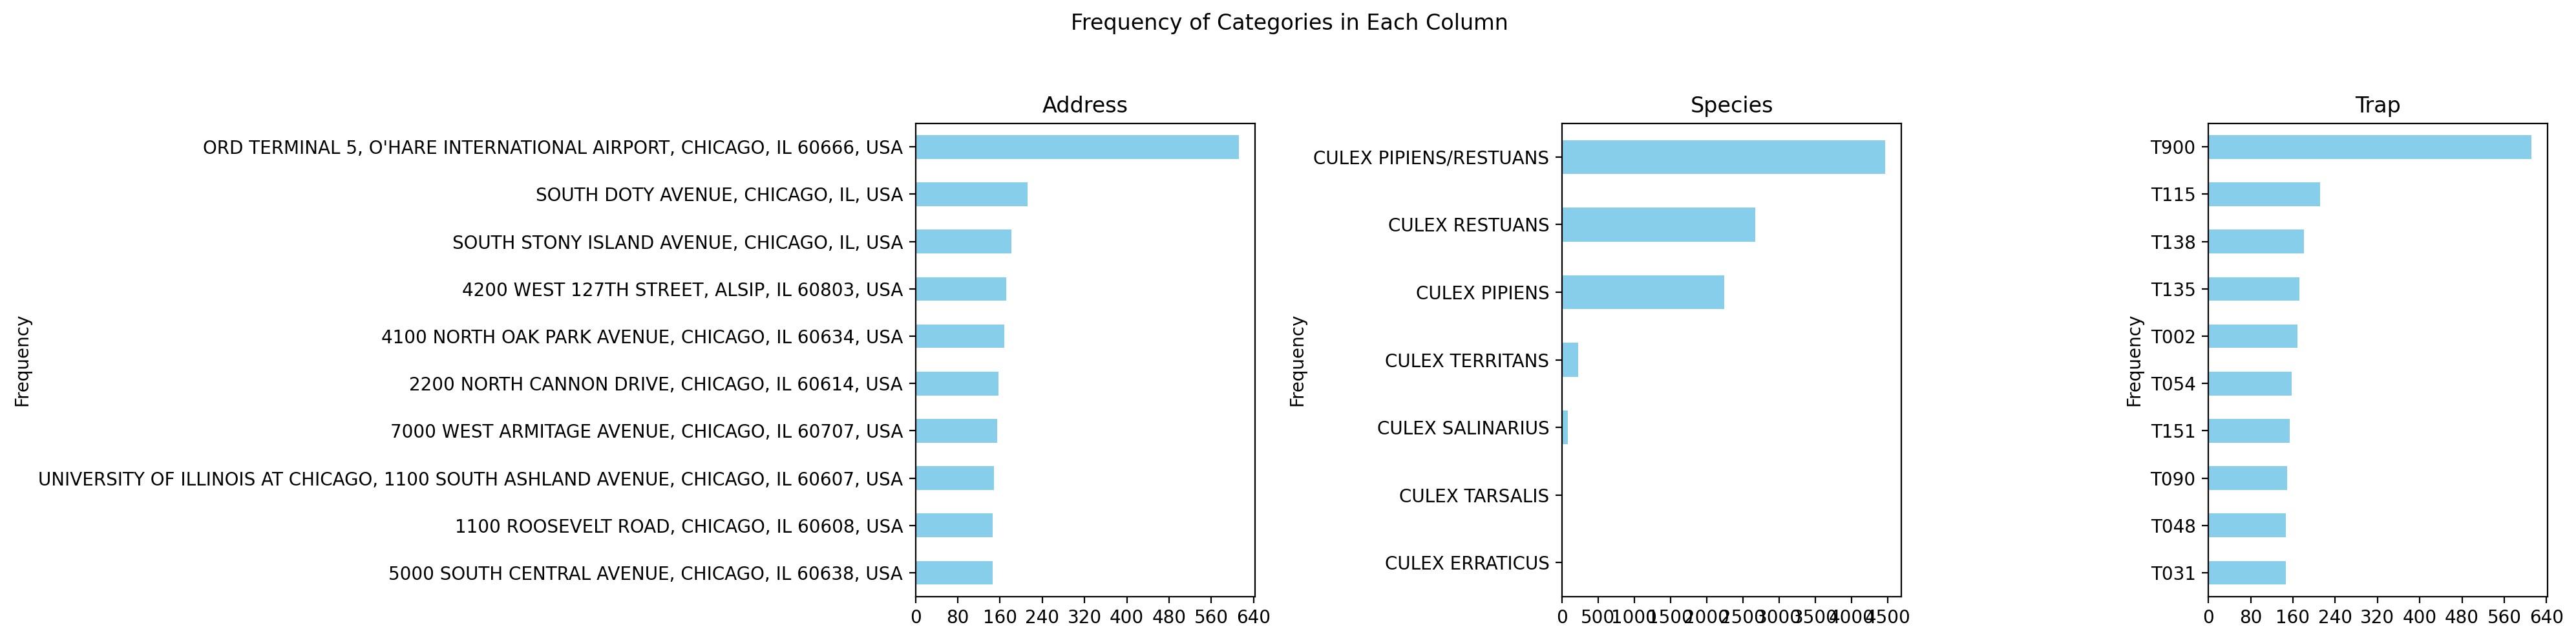

In [1734]:
# Weather has no further categorical columns
plot_category_frequencies_grid(train_categorical)

**Weather Outlier Detection - Numerical Attributes**

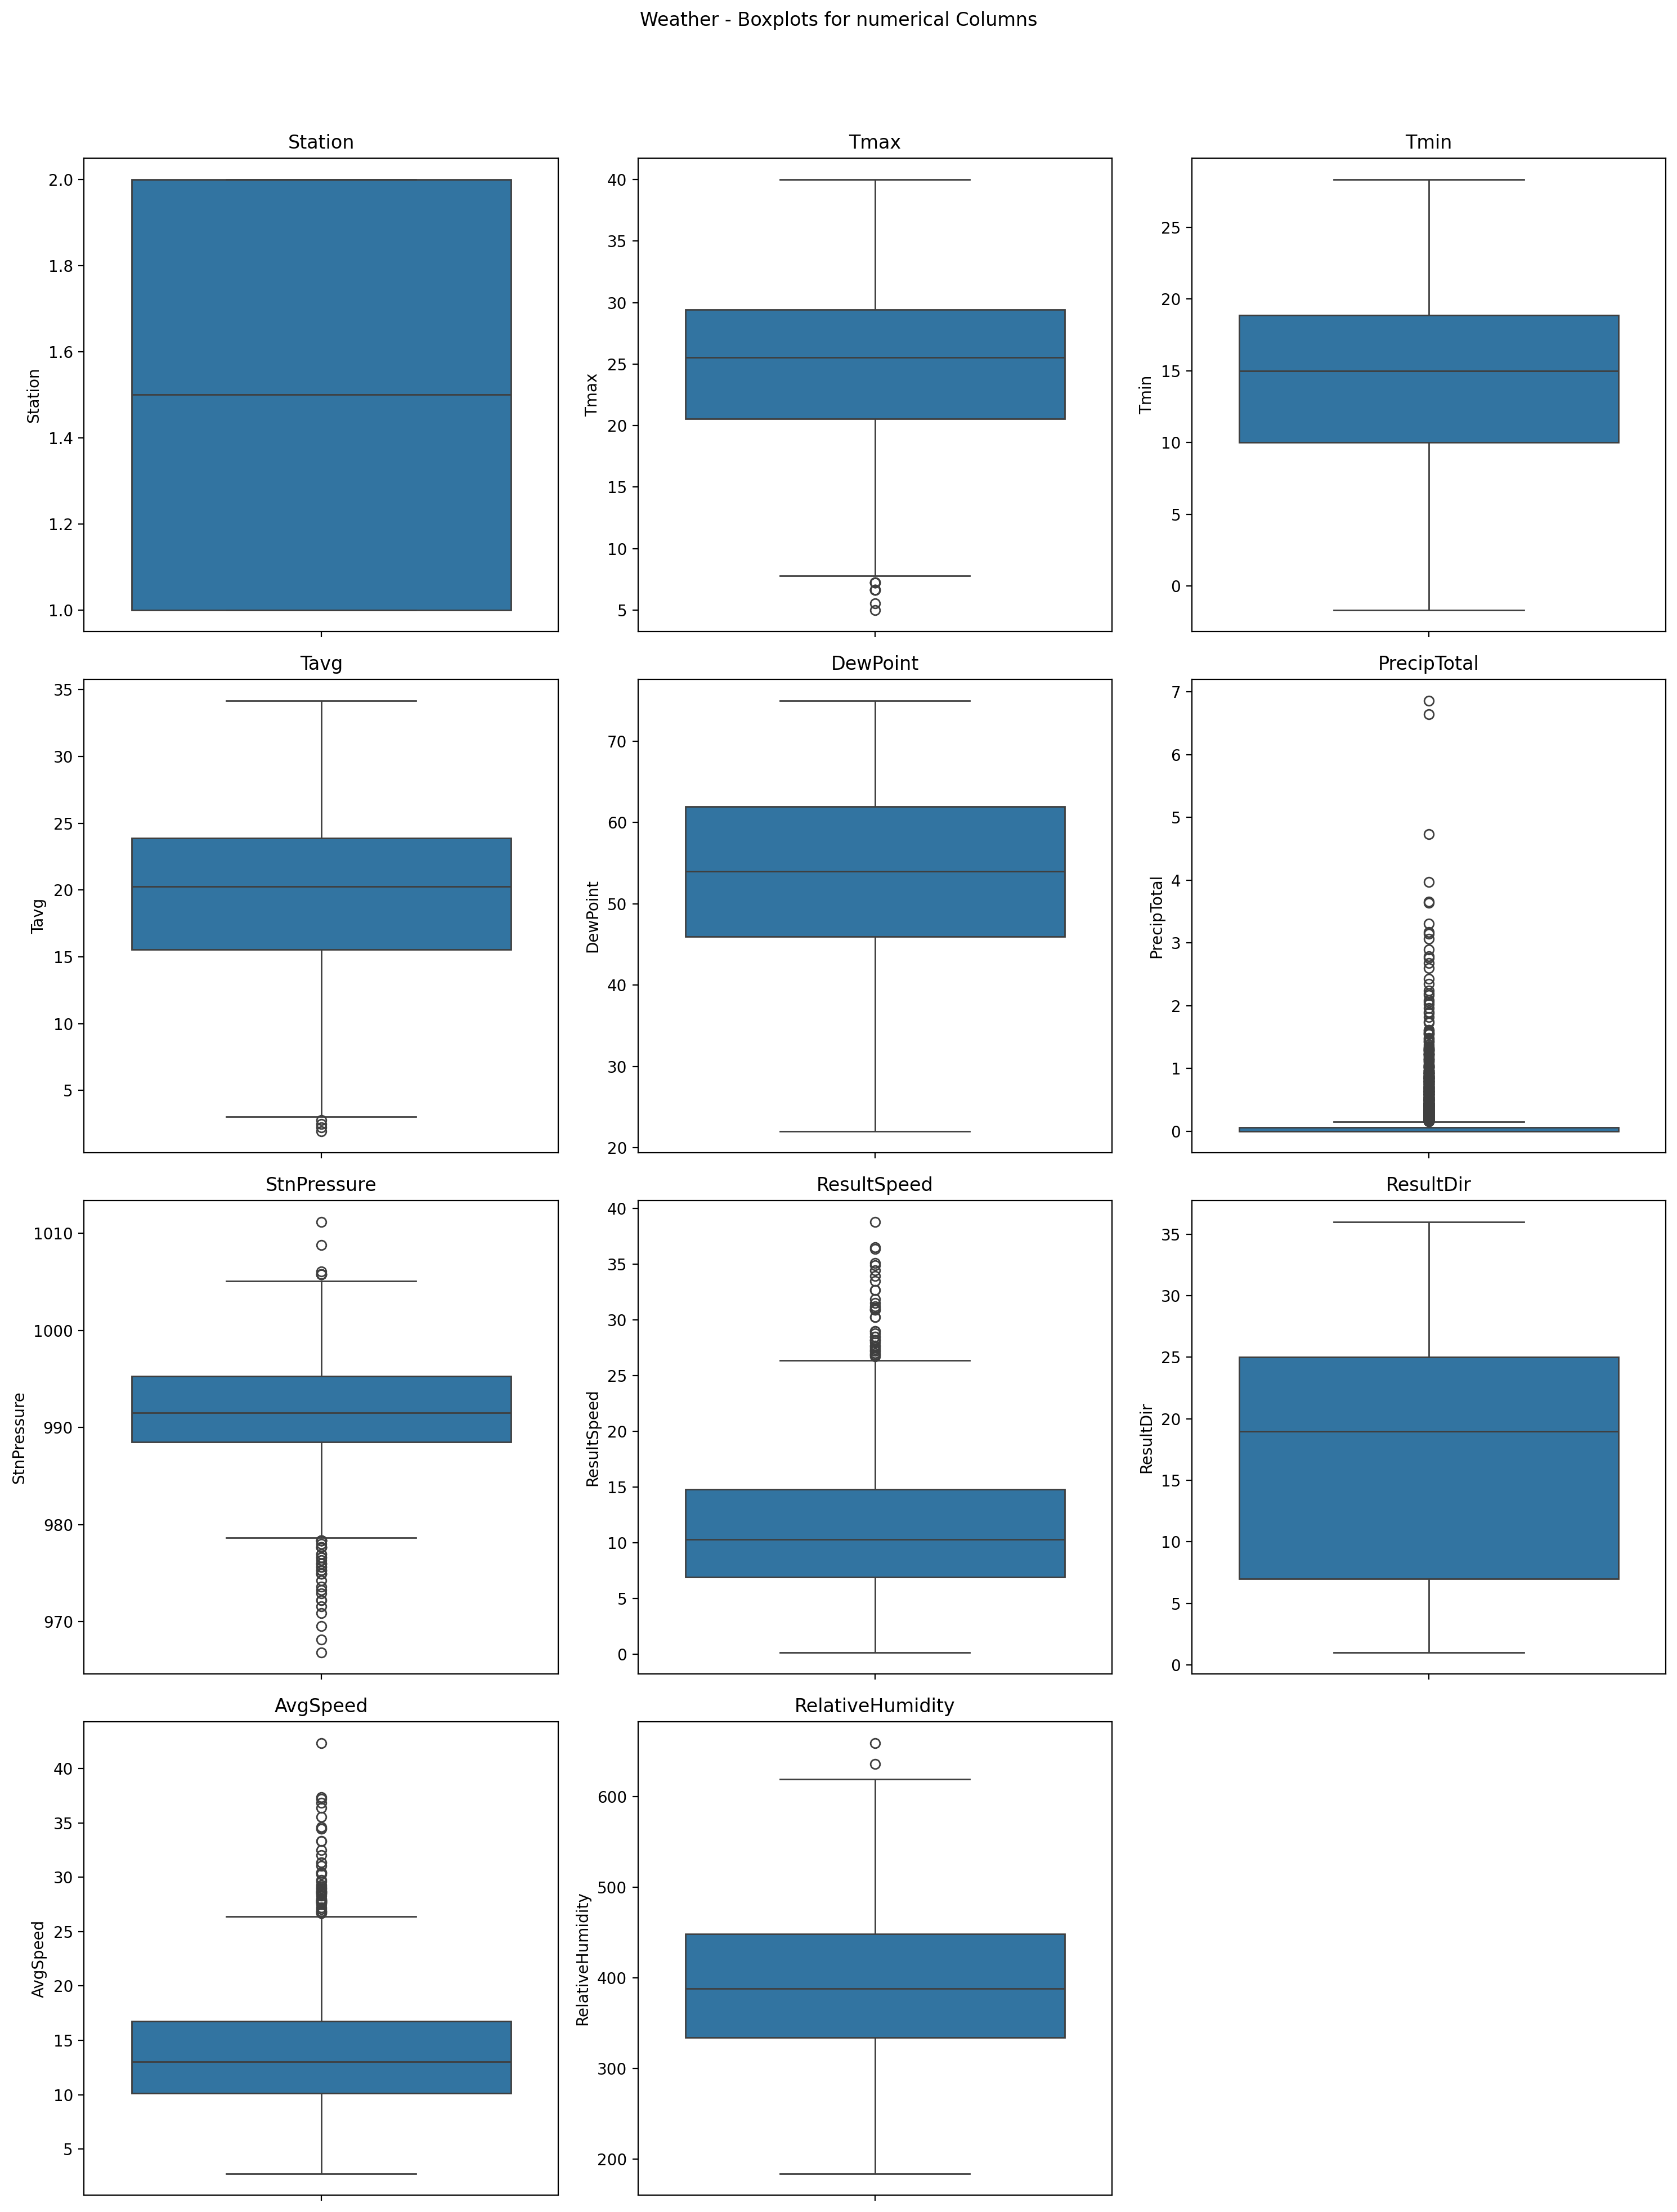

### Station Summary
- Minimum: 1
- Q1: 1.0
- Median: 1.5
- Q3: 2.0
- Maximum: 2

### Tmax Summary
- Minimum: 5.0
- Q1: 20.56
- Median: 25.56
- Q3: 29.44
- Maximum: 40.0

### Tmin Summary
- Minimum: -1.67
- Q1: 10.0
- Median: 15.0
- Q3: 18.89
- Maximum: 28.33

### Tavg Summary
- Minimum: 1.9449999999999998
- Q1: 15.555
- Median: 20.28
- Q3: 23.89
- Maximum: 34.165

### DewPoint Summary
- Minimum: 22
- Q1: 46.0
- Median: 54.0
- Q3: 62.0
- Maximum: 75

### PrecipTotal Summary
- Minimum: 0.0
- Q1: 0.0
- Median: 0.0
- Q3: 0.06
- Maximum: 6.86

### StnPressure Summary
- Minimum: 966.81
- Q1: 988.49
- Median: 991.53
- Q3: 995.26
- Maximum: 1011.18

### ResultSpeed Summary
- Minimum: 0.16
- Q1: 6.92
- Median: 10.3
- Q3: 14.81
- Maximum: 38.79

### ResultDir Summary
- Minimum: 1
- Q1: 7.0
- Median: 19.0
- Q3: 25.0
- Maximum: 36

### AvgSpeed Summary
- Minimum: 2.74
- Q1: 10.14
- Median: 13.04
- Q3: 16.74
- Maximum: 42.33

### RelativeHumidity Summary
- Minimum: 183.64
- Q1: 334.12
- Median: 388.36
- Q3: 448.59
- Maximum: 659.29


In [1735]:
# weather_numerical = Tavg, Dewpoint, precipTotal, StnPressure, Result speed, resultDir. AvgSpeed, Relative Humidity; train_numerical NumMosquitoes, spray_numerical Latitude, longitude
display_grid_boxplots(weather_numerical, "Weather - Boxplots for numerical Columns")
five_number_summary(weather_numerical)



**Train Outlier Detection - Numerical Attributes**

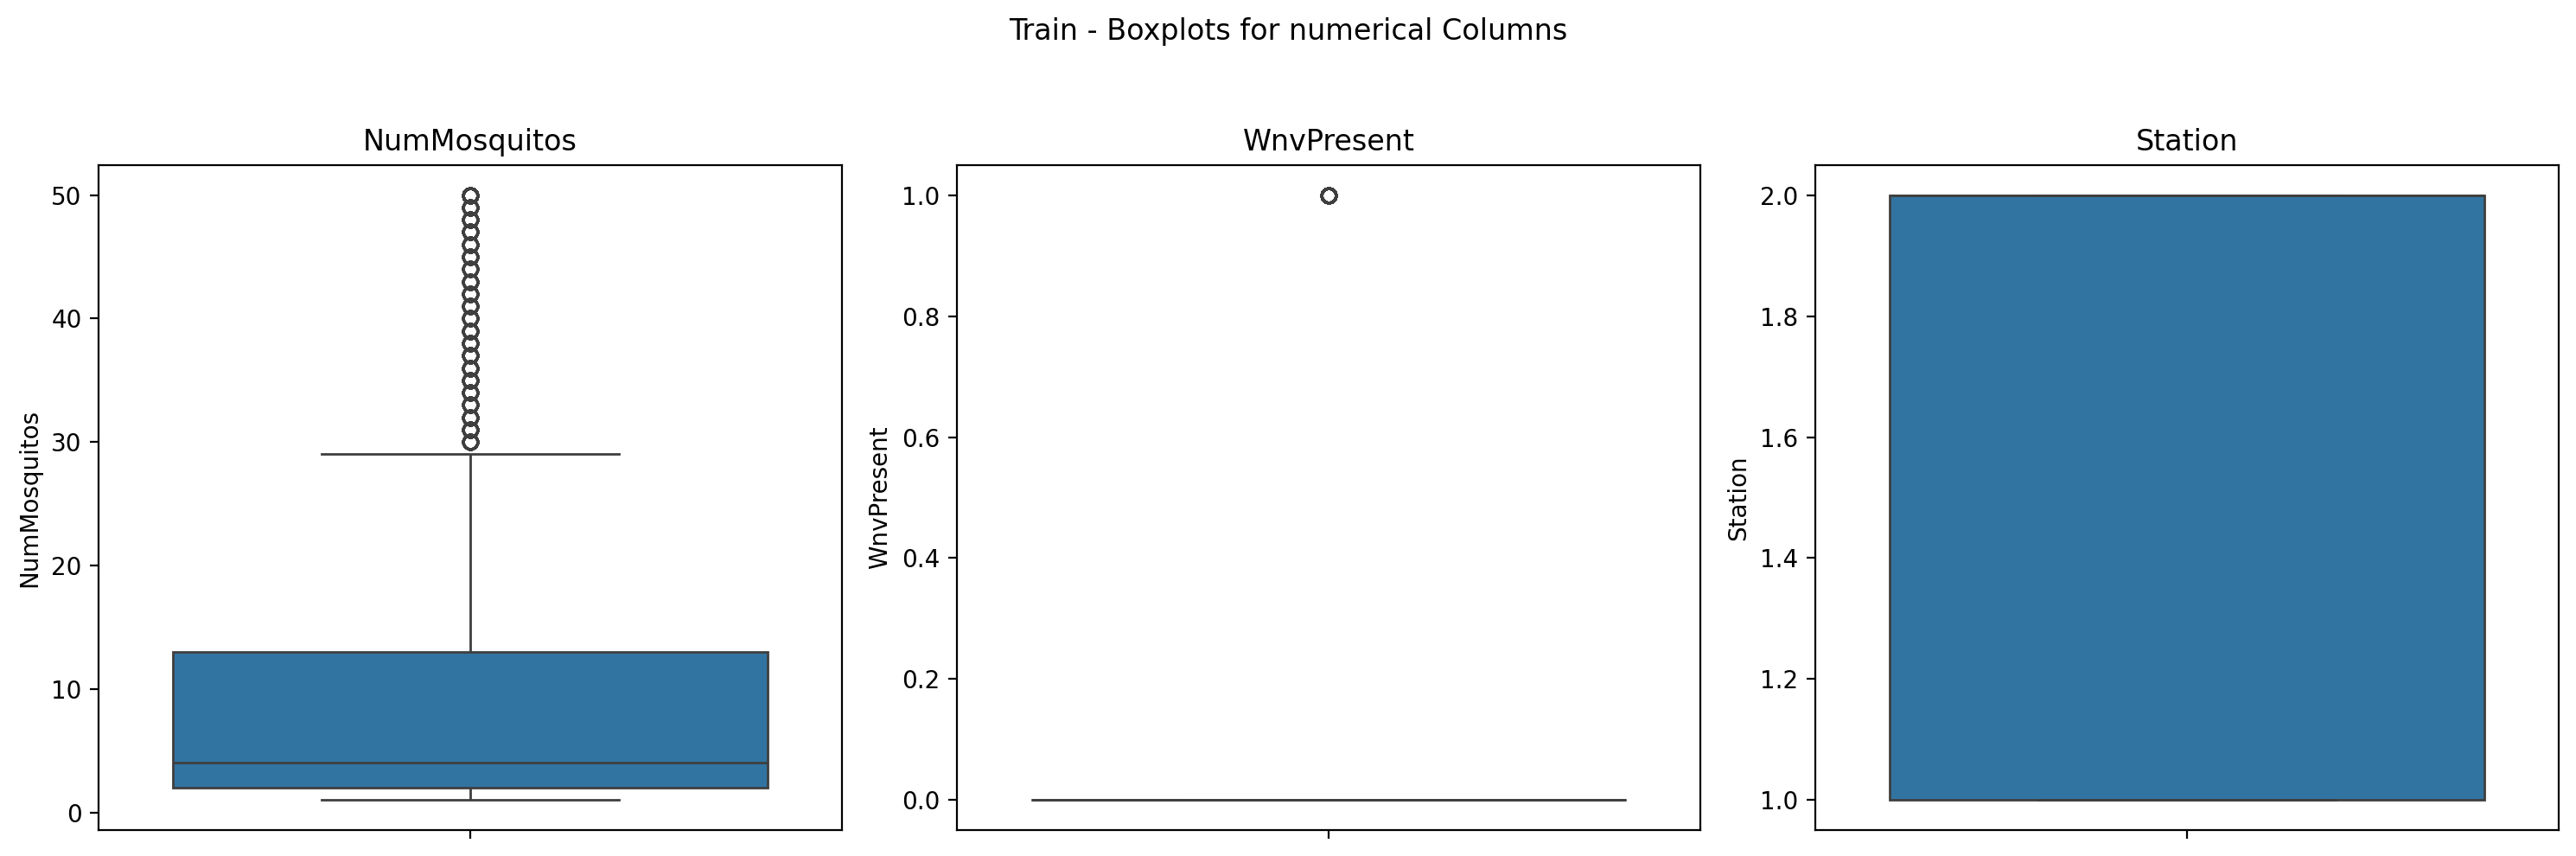

### NumMosquitos Summary
- Minimum: 1
- Q1: 2.0
- Median: 4.0
- Q3: 13.0
- Maximum: 50

### WnvPresent Summary
- Minimum: 0
- Q1: 0.0
- Median: 0.0
- Q3: 0.0
- Maximum: 1

### Station Summary
- Minimum: 1
- Q1: 1.0
- Median: 2.0
- Q3: 2.0
- Maximum: 2


In [1736]:
# weather_numerical = Tavg, Dewpoint, precipTotal, StnPressure, Result speed, resultDir. AvgSpeed, Relative Humidity; train_numerical NumMosquitoes, spray_numerical Latitude, longitude
display_grid_boxplots(train_numerical, "Train - Boxplots for numerical Columns")
five_number_summary(train_numerical)



**Train Outlier Detection - Categorical Attributes**

C:\Users\nilst\AppData\Local\Temp\ipykernel_12268\4129951889.py:15: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  categorical_columns = [col for col in df.columns if df[col].dtype == 'object' or pd.api.types.is_categorical_dtype(df[col])]


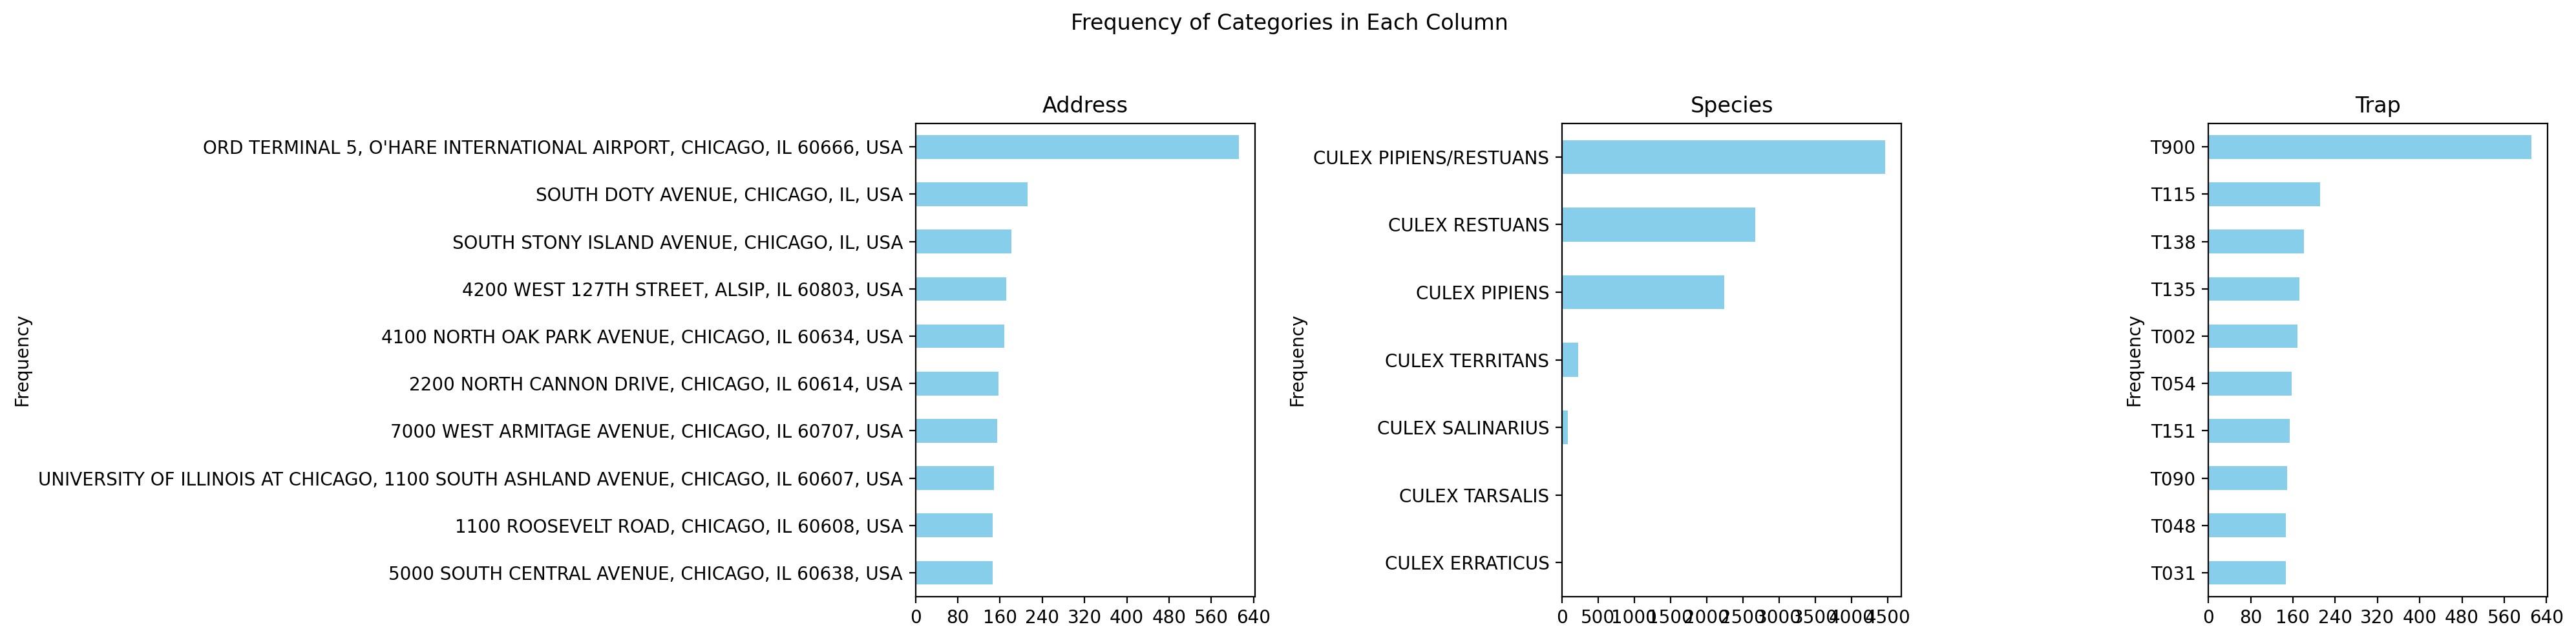

In [1737]:
plot_category_frequencies_grid(train_categorical)

**Spray Outlier Detection - Numerical Attributes**

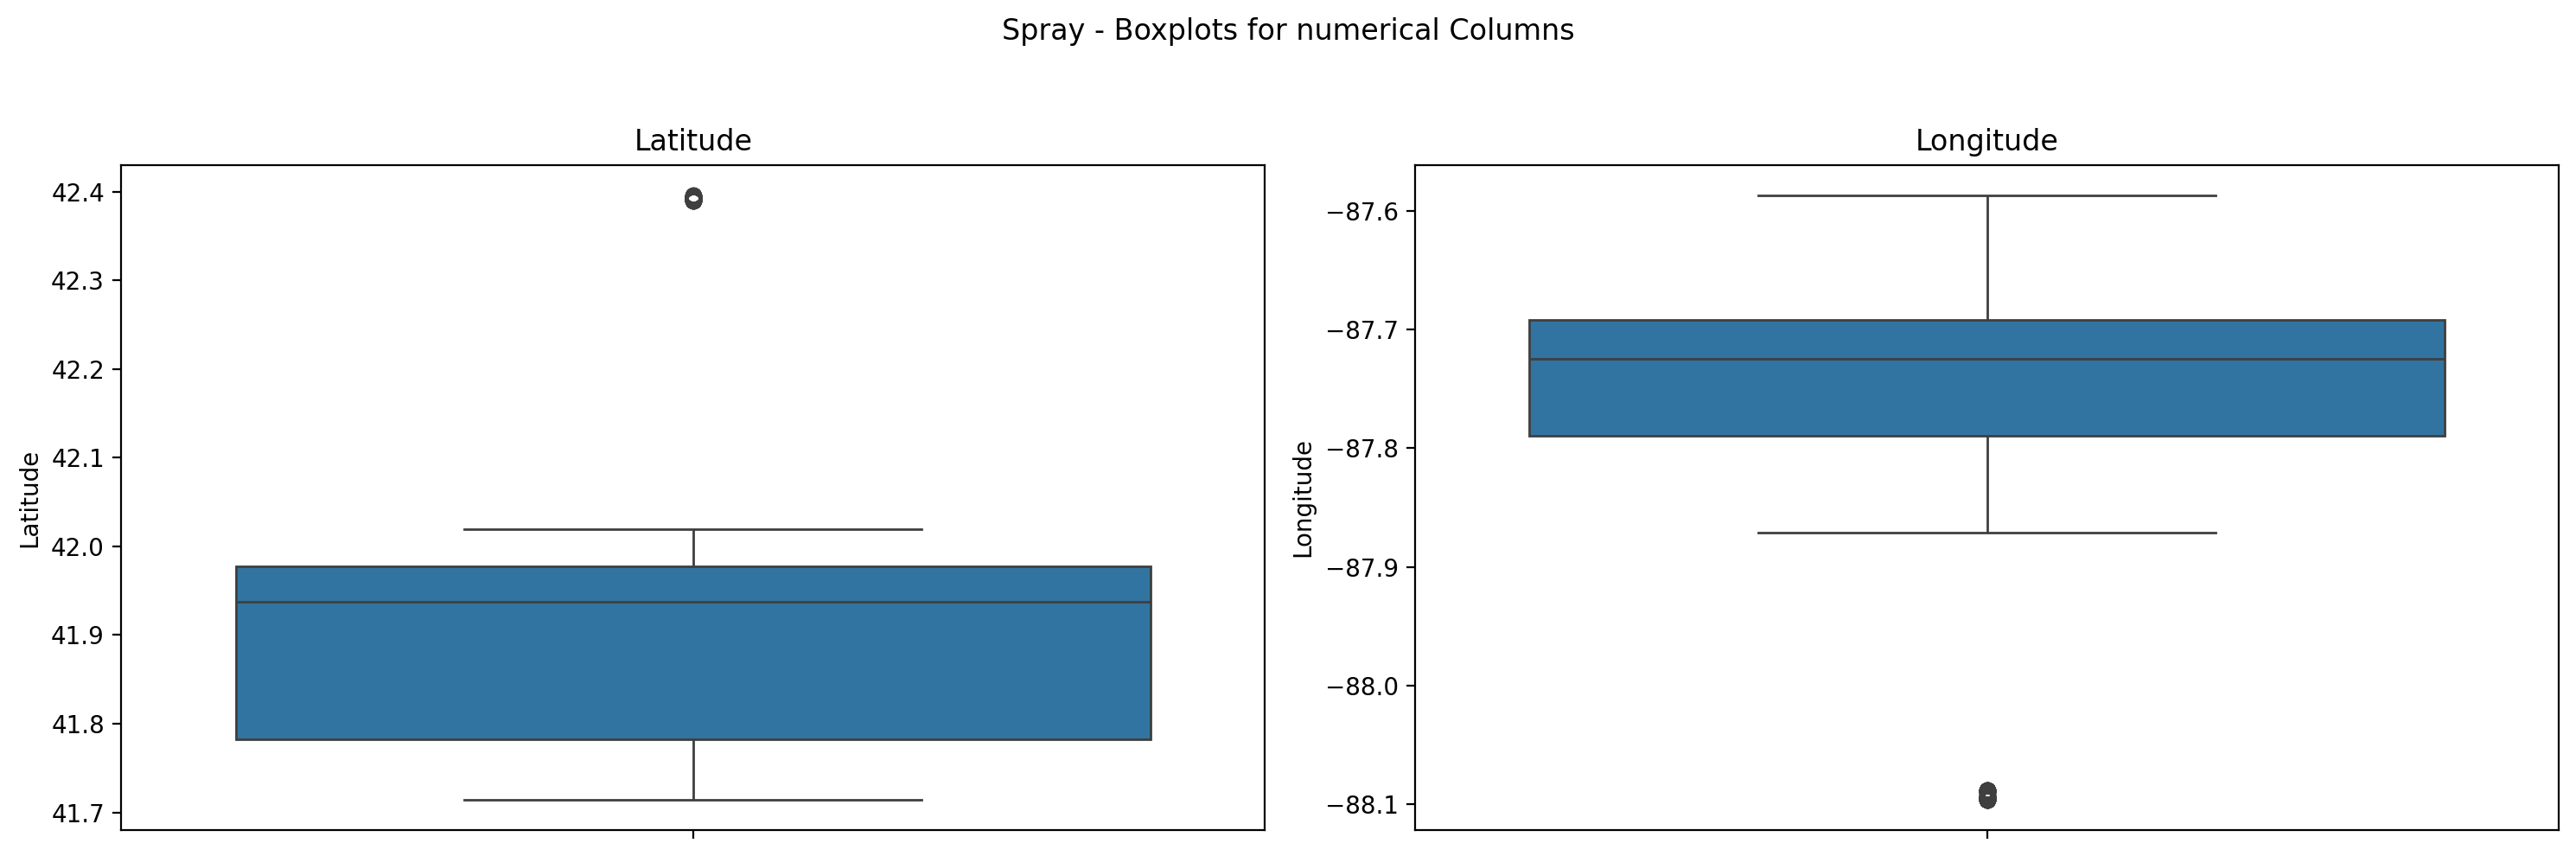

### Latitude Summary
- Minimum: 41.713925
- Q1: 41.78266874999998
- Median: 41.9375783333333
- Q3: 41.9772170833333
- Maximum: 42.3959833333333

### Longitude Summary
- Minimum: -88.0964683333333
- Q1: -87.7896066666667
- Median: -87.72478083333334
- Q3: -87.69210708333333
- Maximum: -87.5867266666667


In [1738]:
display_grid_boxplots(spray_numerical, "Spray - Boxplots for numerical Columns")
five_number_summary(spray_numerical)



**Outlier Detection - Dates**

In [1739]:
# check date range of our data
from IPython.display import Markdown, display

def five_summary_date(data, date_column):
    """
    Compute and display a summary for a date column in a DataFrame using Markdown.
    
    Parameters:
    - data (DataFrame): The DataFrame containing the date column.
    - date_column (str): The name of the date column to summarize.
    """
    if pd.api.types.is_datetime64_any_dtype(data[date_column]):
        # Compute statistics
        min_date = data[date_column].min()
        max_date = data[date_column].max()
        range_date = max_date - min_date
        
        # Attempt to calculate quartiles if relevant
        try:
            q1_date = data[date_column].quantile(0.25)
            median_date = data[date_column].median()
            q3_date = data[date_column].quantile(0.75)
        except TypeError:
            q1_date = "N/A"
            median_date = "N/A"
            q3_date = "N/A"
        
        # Collect the summary in Markdown format
        output = [
            f"### {date_column} Summary",
            f"- Earliest Date: {min_date.strftime('%Y-%m-%d') if pd.notna(min_date) else 'N/A'}",
            f"- Q1 Date: {q1_date.strftime('%Y-%m-%d') if pd.notna(q1_date) else 'N/A'}",
            f"- Median Date: {median_date.strftime('%Y-%m-%d') if pd.notna(median_date) else 'N/A'}",
            f"- Q3 Date: {q3_date.strftime('%Y-%m-%d') if pd.notna(q3_date) else 'N/A'}",
            f"- Latest Date: {max_date.strftime('%Y-%m-%d') if pd.notna(max_date) else 'N/A'}",
            f"- Date Range: {range_date}"
        ]
        
        # Display output as a Markdown block
        display(Markdown('\n'.join(output)))
    else:
        print(f"The column '{date_column}' is not a datetime type.")

five_summary_date(train, 'Date')
five_summary_date(weather, 'Date')
five_summary_date(spray, 'Date')

### Date Summary
- Earliest Date: 2007-05-29
- Q1 Date: 2007-09-05
- Median Date: 2009-08-27
- Q3 Date: 2011-09-23
- Latest Date: 2013-09-26
- Date Range: 2312 days 00:00:00

### Date Summary
- Earliest Date: 2007-05-01
- Q1 Date: 2009-03-16
- Median Date: 2011-01-30
- Q3 Date: 2012-12-15
- Latest Date: 2014-10-31
- Date Range: 2740 days 00:00:00

### Date Summary
- Earliest Date: 2011-08-29
- Q1 Date: 2013-07-17
- Median Date: 2013-08-15
- Q3 Date: 2013-08-22
- Latest Date: 2013-09-05
- Date Range: 738 days 00:00:00

### 4.3 Data Transformation and Integration

**Dummifying species**

In [1740]:
# To differentiate between Mosquitto species, we will create a dummy variable for each species
import pandas as pd

# Assuming 'train' is your DataFrame and 'Species' is the column to check

# Example DataFrame
# train = pd.DataFrame({'Species': ['PIPIENS', 'RESTUANS', 'PIPIENS RESTUANS', 'OTHER']})

species = ["PIPIENS", "RESTUANS"]

# Initialize columns with zeros
for sp in species:
    train[sp] = 0

# Use vectorized string operations to check for presence of species
for sp in species:
    train[sp] = train['Species'].str.contains(sp).astype(int)


train.drop("Species", axis=1, inplace=True)
train.head()

,Date,Address,Trap,NumMosquitos,WnvPresent,WnvRisk_very low,WnvRisk_low,WnvRisk_medium,WnvRisk_high,Station,PIPIENS,RESTUANS
0,2007-05-29,"4100 NORTH OAK PARK AVENUE, CHICAGO, IL 60634,...",T002,1,0,False,False,False,True,1,1,1
1,2007-05-29,"4100 NORTH OAK PARK AVENUE, CHICAGO, IL 60634,...",T002,1,0,False,False,False,True,1,0,1
2,2007-05-29,"6200 NORTH MANDELL AVENUE, CHICAGO, IL 60646, USA",T007,1,0,True,False,False,False,1,0,1
3,2007-05-29,"7900 WEST FOSTER AVENUE, CHICAGO, IL 60656, USA",T015,1,0,False,True,False,False,1,1,1
4,2007-05-29,"7900 WEST FOSTER AVENUE, CHICAGO, IL 60656, USA",T015,4,0,False,True,False,False,1,0,1


In [1741]:
###### Data Integration - Merging Train and Weather Data

In [1742]:


train = train.merge(weather, how='left', on=['Station', 'Date'])
train.head()


,Date,Address,Trap,NumMosquitos,WnvPresent,WnvRisk_very low,WnvRisk_low,WnvRisk_medium,WnvRisk_high,Station,...,AvgSpeed,Year,Month,Day,Year Month,Rainy,Snowy,Windy,Hazy,RelativeHumidity
0,2007-05-29,"4100 NORTH OAK PARK AVENUE, CHICAGO, IL 60634,...",T002,1,0,False,False,False,True,1,...,10.46,2007,5,29,2007 05,0,0,0,1,384.15
1,2007-05-29,"4100 NORTH OAK PARK AVENUE, CHICAGO, IL 60634,...",T002,1,0,False,False,False,True,1,...,10.46,2007,5,29,2007 05,0,0,0,1,384.15
2,2007-05-29,"6200 NORTH MANDELL AVENUE, CHICAGO, IL 60646, USA",T007,1,0,True,False,False,False,1,...,10.46,2007,5,29,2007 05,0,0,0,1,384.15
3,2007-05-29,"7900 WEST FOSTER AVENUE, CHICAGO, IL 60656, USA",T015,1,0,False,True,False,False,1,...,10.46,2007,5,29,2007 05,0,0,0,1,384.15
4,2007-05-29,"7900 WEST FOSTER AVENUE, CHICAGO, IL 60656, USA",T015,4,0,False,True,False,False,1,...,10.46,2007,5,29,2007 05,0,0,0,1,384.15


,WnvPresent,WnvRisk_very low,WnvRisk_low,WnvRisk_medium,WnvRisk_high,PIPIENS,RESTUANS,Tmax,Tmin,Tavg,...,ResultDir,AvgSpeed,Year,Month,Day,Rainy,Snowy,Windy,Hazy,RelativeHumidity
0,0,False,False,False,True,1,1,31.11,15.56,23.335,...,18,10.46,2007,5,29,0,0,0,1,384.15
1,0,False,False,False,True,0,1,31.11,15.56,23.335,...,18,10.46,2007,5,29,0,0,0,1,384.15
2,0,True,False,False,False,0,1,31.11,15.56,23.335,...,18,10.46,2007,5,29,0,0,0,1,384.15
3,0,False,True,False,False,1,1,31.11,15.56,23.335,...,18,10.46,2007,5,29,0,0,0,1,384.15
4,0,False,True,False,False,0,1,31.11,15.56,23.335,...,18,10.46,2007,5,29,0,0,0,1,384.15


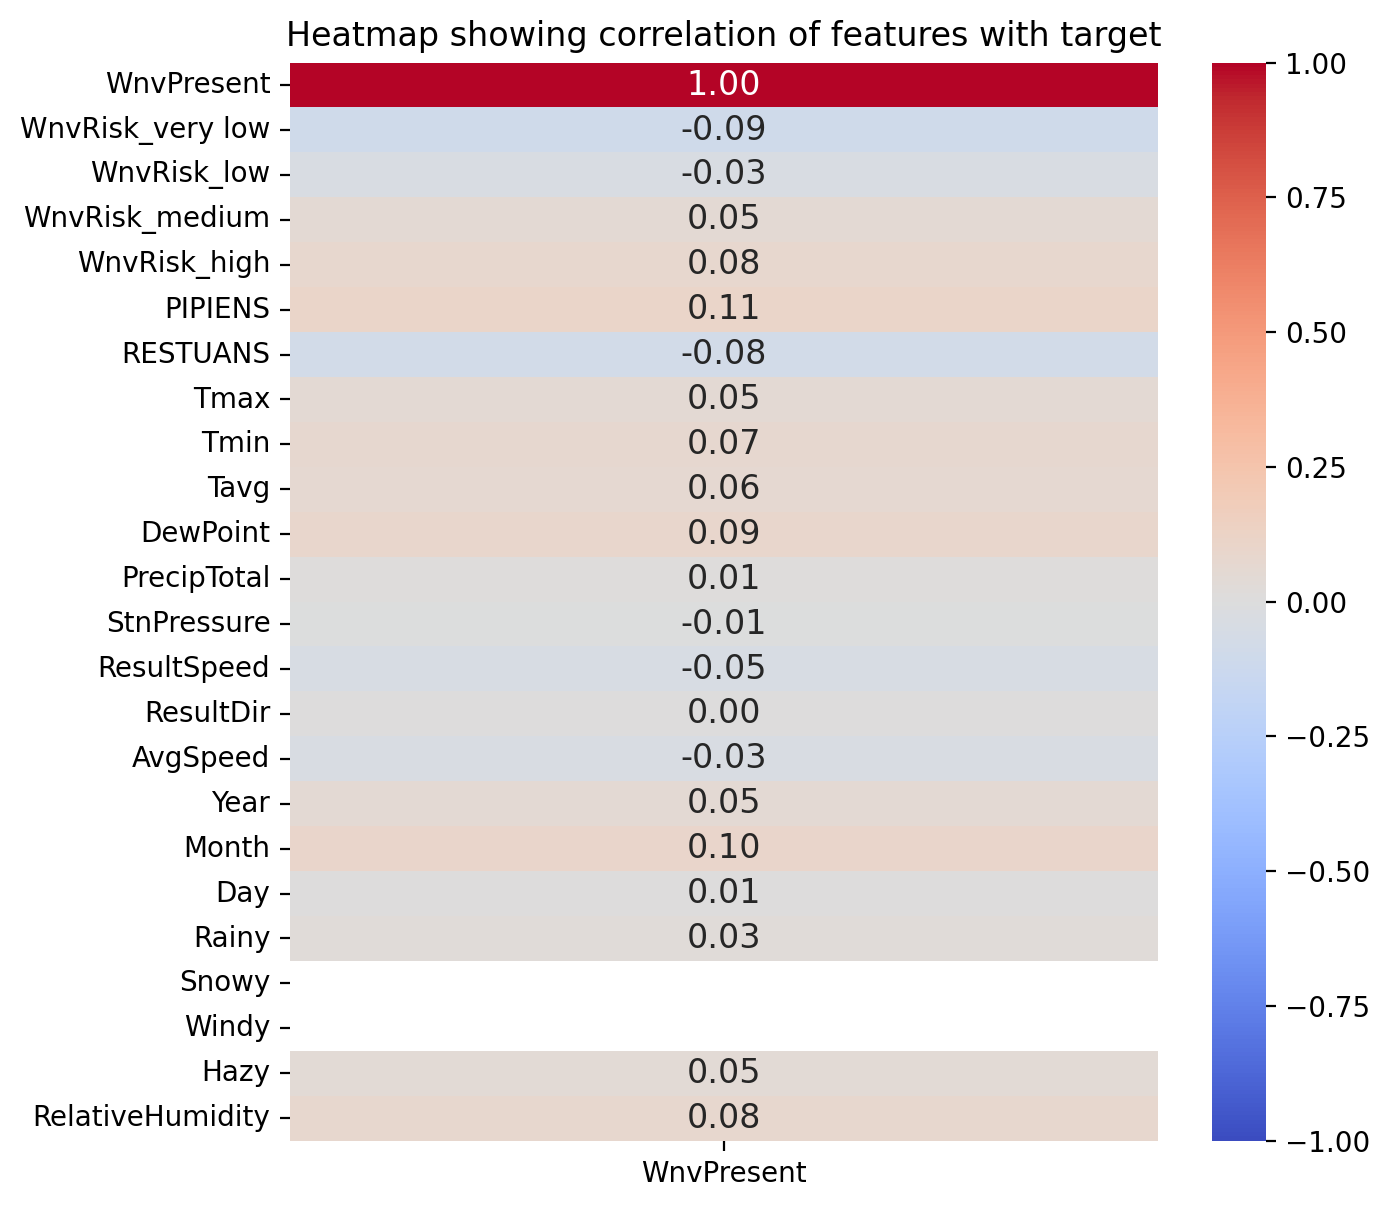

In [1743]:
# # create a temporary dataframe and drop categorical data and variables that are not present in test set
# df_temp = train.drop(["Date", "Station", 
#                               "NumMosquitos", "Trap", 'Year Month', 'Address'], axis=1)
# display(df_temp.head())
# plt.figure(figsize=(7,7))
# plt.title("Heatmap showing correlation of features with target")
# sns.heatmap(df_temp.corr()[["WnvPresent"]], annot=True, cmap="coolwarm", 
#            fmt=".2f", annot_kws={"size":12}, vmin=-1, vmax=1);

In [1744]:
# train.drop([ "AddressNumberAndStreet", "Latitude", "Longitude", 
#                               "NumMosquitos", "Year", "Trap"], axis=1, inplace=True)
# # create a function to transform the weather features to incorporate the lagging effects
# weather['Year Month'] = weather['Date'].dt.strftime('%Y %m')

# def add_weather_stats(df: pd.DataFrame) -> pd.DataFrame:
#     # Adding Year Month columns to aggregrate weather data by year and month
#     weather['Year_Month'] = weather['Date'].dt.strftime('%Y %m')
    
#     # Adding this to use as key for lag variables
#     df['Year Month L1'] = df['Date'] - pd.DateOffset(months=1)
#     df['Year Month L1'] = df['Year Month L1'].dt.strftime('%Y %m')

#     # Creating a temporary pivot table to extract weather states by year month
#     pivot = pd.DataFrame(pd.pivot_table(data=weather, index=['Station','Year_Month'], 
#                                         values=['Tmin', 'Tmax', 'DewPoint', 'PrecipTotal', 'SeaLevel', 
#                                                 'AvgSpeed', 'RelativeHumidity'], aggfunc='mean').to_records())
    
#     # Rename the columns in the pivot table
#     old_col = pivot.drop('Station', axis='columns').columns
#     new_col = old_col + "_"
#     pivot = pivot.rename(columns = dict(zip(old_col.tolist(), new_col.tolist())))
    
#     # Assigning aggregated year month values into train from pivot
#     for item in new_col[1:]:
#         df = pivot[['Station', 'Year_Month_', item]].merge(df, 
#                                                            how='right', left_on=['Station', 'Year_Month_'], 
#                                                            right_on=['Station', 'Year Month'])  \
#                                                                      .rename(columns={item: item + 'L0'})  \
#                                                                      .drop(['Year_Month_'], axis='columns')
        
#         df = pivot[['Station', 'Year_Month_', item]].merge(df, how='right', 
#                                                            left_on=['Station', 'Year_Month_'], 
#                                                            right_on=['Station', 'Year Month L1'])  \
#                                                                      .rename(columns={item: item + 'L1'})  \
#                                                                      .drop(['Year_Month_'], axis='columns')
    
#     return df
  
# train = add_weather_stats(train)
# train = train[(train['Year Month'] != '2007 05') & (train['Year Month'] != '2009 05')]
# train = train.drop(['Year Month', 'Year Month L1', 'Station', 'Date'], axis='columns')
# train.info()



KeyError: "['AddressNumberAndStreet', 'Latitude', 'Longitude'] not found in axis"

In [ ]:
test.to_csv('../data/cleaned_test.csv', index=False)
weather.to_csv('../data/cleaned_weather.csv', index=False)
train.to_csv('../data/cleaned_train.csv', index=False)
spray.to_csv('../data/cleaned_spray.csv', index=False)
